<a href="https://colab.research.google.com/github/uscmlsystems/ml-systems-hw5-ngcxy/blob/main/Pruning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EE 599 HW 5 Part 2: Pruning

Your task in this Colab notebook is to fill out the sections that are specified by **TODO** (please search the keyword `TODO` to make sure you do not miss any).

Prerequisites: set the runtime type to GPU. (Runtime -> Change Runtime Type)

## Initial Setup

This section imports all required packages from PyTorch.

In [1]:
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

Verify that GPU is availble to use.

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

## Create CNN

Note: This section is similar to HW2.

Prepare CIFAR10 dataset.

In [3]:
# Set the batch size for data processing
batch_size = 4

# Define the mean values and standard deviation values for normalization
mean_values = (0.5, 0.5, 0.5)  # Mean values for red, green, and blue channels
std_values = (0.5, 0.5, 0.5)   # Standard deviation values for red, green, and blue channels

# Define the transformation pipeline
transform = transforms.Compose([
    transforms.ToTensor(),                  # Convert images to tensors
    transforms.Normalize(mean_values, std_values)  # Normalize tensor values
])

# Load the CIFAR10 training dataset and apply the defined transformations
trainset = torchvision.datasets.CIFAR10(root="./", train=True,
                                        download=True, transform=transform)

# Create a DataLoader to efficiently load and process training data in batches
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# Load the CIFAR10 test dataset and apply the same transformations as for training
testset = torchvision.datasets.CIFAR10(root="./", train=False,
                                       download=True, transform=transform)

# Create a DataLoader for test data
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:04<00:00, 41722069.83it/s]


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


Define a simple CNN that classifies CIFAR images.

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Define the layers of the neural network architecture

        # First convolutional layer: 3 input channels, 6 output channels, kernel size 5x5
        self.conv1 = nn.Conv2d(3, 6, 5, bias=False)

        # Max pooling layer with kernel size 2x2 and stride 2
        self.pool = nn.MaxPool2d(2, 2)

        # Second convolutional layer: 6 input channels, 16 output channels, kernel size 5x5
        self.conv2 = nn.Conv2d(6, 16, 5, bias=False)

        # Fully connected (dense) layers

        # First fully connected layer: 16*5*5 input features, 120 output features
        self.fc1 = nn.Linear(16 * 5 * 5, 120, bias=False)

        # Second fully connected layer: 120 input features, 84 output features
        self.fc2 = nn.Linear(120, 84, bias=False)

        # Third fully connected layer: 84 input features, 10 output features (for classification)
        self.fc3 = nn.Linear(84, 10, bias=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Forward pass through the neural network

        # Apply first convolutional layer, followed by ReLU activation and max pooling
        x = self.pool(F.relu(self.conv1(x)))

        # Apply second convolutional layer, followed by ReLU activation and max pooling
        x = self.pool(F.relu(self.conv2(x)))

        # The output from the convolutional and pooling layers is in the form of a
        # 3D tensor (height, width, depth or channels).
        # To feed this tensor into a fully connected layer,
        # it needs to be flattened into a 1D tensor.
        # Reshape tensor for fully connected layers
        # A2D tensor with a shape of [batch_size, 16 * 5 * 5].
        x = x.view(-1, 16 * 5 * 5)

        # Apply first fully connected layer, followed by ReLU activation
        x = F.relu(self.fc1(x))

        # Apply second fully connected layer, followed by ReLU activation
        x = F.relu(self.fc2(x))

        # Apply third fully connected layer (output layer)
        x = self.fc3(x)

        return x

# Create an instance of the neural network and move it to the specified device (e.g., GPU)
net = Net().to(device)

Train this CNN on the training dataset (this may take a few moments).

In [5]:
def train(model: nn.Module, dataloader: DataLoader, epoch_num: int):
    # Define the loss criterion and optimizer
    criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # SGD optimizer with momentum

    for epoch in range(epoch_num):  # Loop over the dataset for multiple epochs
        running_loss = 0.0

        # Iterate over mini-batches of data
        for i, data in enumerate(dataloader, 0):
            # Get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            inputs = inputs.to(device)  # Move inputs to the specified device
            labels = labels.to(device)  # Move labels to the specified device

            # Zero the gradients in the optimizer
            optimizer.zero_grad()

            # Forward pass + backward pass (backpropagation) + optimization
            outputs = model(inputs)  # Forward pass through the model
            loss = criterion(outputs, labels)  # Calculate the loss
            loss.backward()  # Compute gradients
            optimizer.step()  # Update model parameters

            # Print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:  # Print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training')  # Training loop is complete

In [6]:
train(net, trainloader, 2)

[1,  2000] loss: 2.257
[1,  4000] loss: 1.901
[1,  6000] loss: 1.720
[1,  8000] loss: 1.626
[1, 10000] loss: 1.526
[1, 12000] loss: 1.494
[2,  2000] loss: 1.436
[2,  4000] loss: 1.396
[2,  6000] loss: 1.382
[2,  8000] loss: 1.358
[2, 10000] loss: 1.329
[2, 12000] loss: 1.336
Finished Training


Let us look at how the network performs on the test dataset.

In [7]:
# A function to evaluate the performance of a given neural network model
# using a test dataset.
# It calculates the accuracy of the model's predictions on the test data.
def calculate_accuracy(model: nn.Module, dataloader: DataLoader, max_samples=None) -> float:
    correct_predictions = 0  # Initialize the count of correctly predicted samples
    total_samples = 0    # Initialize the count of total samples
    inference_count = 0  # Initialize the count of inferences made

    with torch.no_grad():  # Disable gradient calculation for inference
        for batch_data in dataloader:
            images, labels = batch_data  # Separate images and labels from the batch

            images = images.to(device)  # Move images to the specified device
            labels = labels.to(device)  # Move labels to the specified device

            outputs = model(images)  # Forward pass to get model predictions
            _, predicted = torch.max(outputs.data, 1)  # Get predicted class indices

            total_samples += labels.size(0)  # Increment the total count of samples
            correct_predictions += (predicted == labels).sum().item()  # Count correct predictions

            if max_samples:  # Check if a maximum number of samples for testing is specified
                inference_count += images.shape[0]  # Increment the count of inferences made
                if inference_count > max_samples:  # Stop testing if maximum samples reached
                    break

    accuracy = 100 * correct_predictions / total_samples  # Calculate the accuracy as a percentage
    return accuracy

score = calculate_accuracy(net, testloader)
print('Accuracy of the network on the test images: {}%'.format(score))

Accuracy of the network on the test images: 53.02%


## Measure Sparsity
Print out the sparsity of each layer and the whole model's sparsity.

In [8]:
def measure_sparsity(model:nn.Module):
    """
    Print the sparsity information of LeNet5 models.

    Args:
    - model         (nn.Module): the given LeNet5

    """
    # The layers in the LeNet5 model
    module_name = ['conv1', 'conv2', 'fc1', 'fc2', 'fc3']
    # The count variable to accumulate the counts within the layers
    global_zeros = 0
    global_elements = 0

    for layer in module_name:
        module = getattr(model, layer)
        # count the number of zeros in the weights tensor
        num_zeros = torch.sum(module.weight == 0)
        # the total elements of the weights tensor
        num_element = module.weight.nelement()
        # the sparsity is ratio of zeros to total element amounts
        sparsity = num_zeros/num_element
        # print the sparsity information of the layer
        print(f'Sparsity in {layer}weight: {100*sparsity:.2f}%')
        # update the count of the whole model
        global_zeros += num_zeros
        global_elements += num_element

    # print the global sparsity information
    global_sparsity = global_zeros/global_elements
    print(f'Global Sparsity: {100*global_sparsity:.2f}%')

Initially, a model typically does not contain any deliberate zero values within its parameters.

In [9]:
measure_sparsity(net)

Sparsity in conv1weight: 0.00%
Sparsity in conv2weight: 0.00%
Sparsity in fc1weight: 0.00%
Sparsity in fc2weight: 0.00%
Sparsity in fc3weight: 0.00%
Global Sparsity: 0.00%


## Visualize Weights

Take each layer of our network and plot the historgram of its parameters.

In [10]:
def analyze_layer_weights(layer_name: str, weight: torch.Tensor):
    # Extract and flatten the weights of the given layer
    layer_weights = weight.data.cpu().view(-1)

    plt.figure(figsize=(5, 4))

    # Plot a histogram of the flattened layer weights
    plt.hist(layer_weights, density=True, bins=50)
    plt.title(f"{layer_name} Weights Histogram")
    plt.xlabel("Weight Value")
    plt.ylabel("Density")

    plt.show()

## Unstructured Pruning

We explore unstructured pruning via `torch.util.prune`, a method that relies on the concept of masks to selectively disable weights within the model. Weights marked with a `1` are preserved, while those marked as `0` are effectively pruned away, allowing us to study the impact of this pruning strategy on our model's performance.

### **TODO 1:** Local Random Pruning
Utilize the [`random_unstructured`](https://pytorch.org/docs/stable/generated/torch.nn.utils.prune.random_unstructured.html) function from the `torch.util.prune` library on the `conv1` layer. This function randomly prunes weights by generating a mask, simulating a scenario where certain connections are deemed non-essential. Your goal is to analyze the before-and-after effects of this pruning technique on model performance.

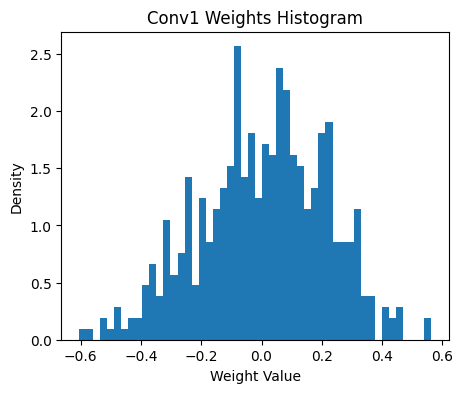

tensor([[[-0.0570,  0.0844, -0.0320,  0.1385,  0.0497],
         [-0.0860, -0.0088,  0.1622,  0.1733,  0.0213],
         [-0.1371,  0.0866,  0.0266,  0.1475,  0.1898],
         [ 0.0163,  0.0822,  0.0235,  0.0440,  0.0563],
         [-0.0195,  0.0645,  0.0992,  0.1130,  0.0573]],

        [[-0.0768, -0.0579, -0.0249,  0.0257, -0.0437],
         [-0.1898, -0.0498, -0.0486,  0.1080,  0.0559],
         [-0.1633, -0.2005,  0.0933,  0.0900,  0.0812],
         [-0.1836, -0.1617, -0.0284, -0.0414,  0.0967],
         [-0.1024, -0.1393, -0.0704,  0.1014,  0.0679]],

        [[-0.0850, -0.0633,  0.1979,  0.2086,  0.2062],
         [-0.0754,  0.0606,  0.0633,  0.1319,  0.2425],
         [-0.0771, -0.1009,  0.1393,  0.2310,  0.1171],
         [-0.0458,  0.0158,  0.2107,  0.3010,  0.0562],
         [-0.0699,  0.0232,  0.1143, -0.0028,  0.0420]]], device='cuda:0',
       grad_fn=<SliceBackward0>)


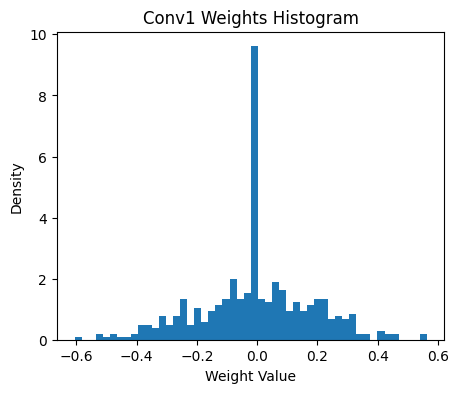

tensor([[[-0.0570,  0.0000, -0.0320,  0.0000,  0.0497],
         [-0.0860, -0.0088,  0.1622,  0.0000,  0.0000],
         [-0.1371,  0.0866,  0.0000,  0.0000,  0.1898],
         [ 0.0000,  0.0822,  0.0235,  0.0000,  0.0563],
         [-0.0195,  0.0645,  0.0992,  0.1130,  0.0000]],

        [[-0.0000, -0.0000, -0.0249,  0.0257, -0.0000],
         [-0.1898, -0.0498, -0.0486,  0.0000,  0.0559],
         [-0.0000, -0.2005,  0.0933,  0.0900,  0.0812],
         [-0.1836, -0.1617, -0.0284, -0.0414,  0.0967],
         [-0.1024, -0.1393, -0.0704,  0.1014,  0.0679]],

        [[-0.0000, -0.0633,  0.1979,  0.0000,  0.0000],
         [-0.0754,  0.0606,  0.0633,  0.1319,  0.2425],
         [-0.0771, -0.1009,  0.1393,  0.2310,  0.1171],
         [-0.0458,  0.0000,  0.2107,  0.3010,  0.0562],
         [-0.0699,  0.0232,  0.0000, -0.0028,  0.0420]]], device='cuda:0',
       grad_fn=<SliceBackward0>)


In [15]:
import copy
import torch.nn.utils.prune as prune

# deep copy a new model for pruning
net_prune_rand = copy.deepcopy(net)
layer1 = net_prune_rand.conv1

# Plot the histogram of the weights of the first convolutional layer before pruning
analyze_layer_weights('Conv1', layer1.weight)

# Print the first filter in the first convolutional layer before pruning
print(layer1.weight[0, :, :, :])

# TODO: Prune the weights of the first convolutional layer
prune.random_unstructured(layer1, "weight", 0.2)

# Plot the histogram of the weights of the first convolutional layer after pruning
analyze_layer_weights('Conv1', layer1.weight)

# Print the first filter in the first convolutional layer after pruning
print(layer1.weight[0, :, :, :])

In [16]:
# Print the sparsity information of the pruned model
measure_sparsity(net_prune_rand)

score = calculate_accuracy(net_prune_rand, testloader)
print('Accuracy of the network on the test images: {}%'.format(score))

Sparsity in conv1weight: 20.00%
Sparsity in conv2weight: 0.00%
Sparsity in fc1weight: 0.00%
Sparsity in fc2weight: 0.00%
Sparsity in fc3weight: 0.00%
Global Sparsity: 0.15%
Accuracy of the network on the test images: 49.94%


### **TODO 2:** L1 Pruning Across the Model
Random pruning might lead to unpredictable outcomes. A more systematic approach involves using L1 norm pruning, targeting the least significant weights based on their absolute values. Apply [`l1_unstructured`](https://pytorch.org/docs/stable/generated/torch.nn.utils.prune.l1_unstructured.html) pruning to all convolutional and fully-connected layers, adjusting the sparsity levels to 30% and 40% respectively.

In [17]:
net_prune_l1 = copy.deepcopy(net)

# TODO: Prune out 30% of the weights in conv layers and 40% of the weights in fc layers
for name, module in net_prune_l1.named_modules():
    if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear)):
        prune.l1_unstructured(module, name='weight', amount=0.3 if isinstance(module, torch.nn.Conv2d) else 0.4)


In [18]:
measure_sparsity(net_prune_l1)

score = calculate_accuracy(net_prune_l1, testloader)
print('Accuracy of the network on the test images: {}%'.format(score))

Sparsity in conv1weight: 30.00%
Sparsity in conv2weight: 30.00%
Sparsity in fc1weight: 40.00%
Sparsity in fc2weight: 40.00%
Sparsity in fc3weight: 40.00%
Global Sparsity: 39.54%
Accuracy of the network on the test images: 51.72%


### **TODO 3:** Global Pruning for Network
The use of random pruning can yield unpredictable outcomes. A more effective approach involves employing the L1 norm (absolute value) as a criterion for eliminating the least impactful values within the model. Apply the [`global_unstructured`](https://pytorch.org/docs/stable/generated/torch.nn.utils.prune.global_unstructured.html) function across all model parameters to reduce the overall parameter count by 40%. Note that with global pruning, the proportion of pruned parameters may vary between different layers of the model.

In [23]:
net_prune_glob= copy.deepcopy(net)

parameters_to_prune = []
for name, module in net_prune_glob.named_modules():
    if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear)):
        parameters_to_prune.append((module, 'weight'))

# TODO: Perform global pruning to the model
prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.4
)

In [24]:
measure_sparsity(net_prune_glob)

score = calculate_accuracy(net_prune_glob, testloader)
print('Accuracy of the network on the test images: {}%'.format(score))

Sparsity in conv1weight: 7.56%
Sparsity in conv2weight: 18.08%
Sparsity in fc1weight: 44.63%
Sparsity in fc2weight: 26.45%
Sparsity in fc3weight: 18.10%
Global Sparsity: 40.00%
Accuracy of the network on the test images: 52.97%


### **TODO 4:** Iterative Pruning

To maintain the model's effectiveness post-pruning, we adopt an iterative approach that combines pruning and fine-tuning. Your task involves completing the `iterative_pruning` function. This process involves repeatedly pruning the model using `global_unstructured` method, followed by fine-tuning model of one epoch to adjust to the changes (and print the sparsity information at the end of each iteration). The goal is to selectively reduce the model's complexity while preserving the performance.


In [27]:
def iter_pruning(model: nn.Module,
                 train_loader: DataLoader,
                 num_iter: int,
                 prune_ratio: float):
    """
    The iterative process of pruning and finetuning.

    Args:
    - model         (nn.Module): The neural network model to be pruned.
    - train_loader (DataLoader): DataLoader object providing the training dataset.
    - test_loader  (DataLoader): DataLoader object providing the test dataset.
    - num_iter            (int): The number of the iterations
    - prune_ratio       (float): The pruning ratio in each iteration

    """

    # TODO: Add your code here.
    for iter in range(num_iter):

      parameters_to_prune = []

      for name, module in model.named_modules():
          if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear)):
              parameters_to_prune.append((module, 'weight'))

      prune.global_unstructured(
          parameters_to_prune,
          pruning_method=prune.L1Unstructured,
          amount=prune_ratio
      )

      train(model, train_loader, iter)


In [28]:
net_prune_iter = copy.deepcopy(net)
iter_pruning(net_prune_iter, trainloader, 3, 0.2)

Finished Training
[1,  2000] loss: 1.236
[1,  4000] loss: 1.227
[1,  6000] loss: 1.221
[1,  8000] loss: 1.201
[1, 10000] loss: 1.206
[1, 12000] loss: 1.211
Finished Training
[1,  2000] loss: 1.124
[1,  4000] loss: 1.105
[1,  6000] loss: 1.120
[1,  8000] loss: 1.138
[1, 10000] loss: 1.128
[1, 12000] loss: 1.119
[2,  2000] loss: 1.056
[2,  4000] loss: 1.068
[2,  6000] loss: 1.070
[2,  8000] loss: 1.059
[2, 10000] loss: 1.077
[2, 12000] loss: 1.083
Finished Training


In [29]:
score = calculate_accuracy(net_prune_glob, testloader)
print('Accuracy of the network on the test images: {}%'.format(score))

Accuracy of the network on the test images: 52.97%
